# Импортируем датасет если работаем на colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Импорт либ

In [ ]:
import numpy as np
import pandas as pd
import os
import zipfile
import shutil
from tqdm import tqdm

import torch
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models

In [ ]:
print(os.listdir("/content/drive/MyDrive"))
root_to_zip = '/content/drive/MyDrive/plates.zip'

['Colab Notebooks', 'plates.zip']


In [ ]:
with zipfile.ZipFile(root_to_zip, 'r') as zip_obj:
    zip_obj.extractall('/content/')

In [ ]:
print(os.listdir("/content"))
print(os.listdir("/content/plates"))

['.config', 'drive', '__MACOSX', 'plates', 'sample_data']
['test', 'train', '.DS_Store']


In [ ]:
#!rm -r /content/plates

In [ ]:
data_root = '/content/plates/'
print(os.listdir(data_root))

['test', 'train', '.DS_Store']


In [ ]:
train_dir = '/content/train'
val_dir = '/content/val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 2211.08it/s]


In [ ]:
!ls /content/train

cleaned  dirty


In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.CenterCrop(200),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Определение трансформаций для валидационного набора данных
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Создание обучающего и валидационного наборов данных с использованием определенных трансформаций
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

# Определение размера пакета для загрузчиков данных
batch_size = 8

# Создание загрузчиков данных для обучающего и валидационного наборов данных
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
len(train_dataloader), len(train_dataset)

(4, 32)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


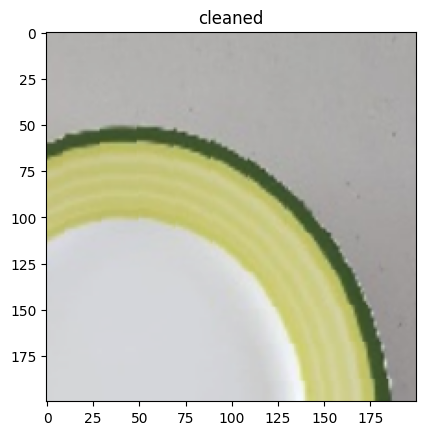

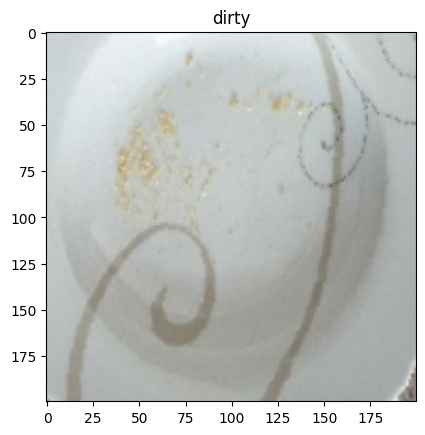

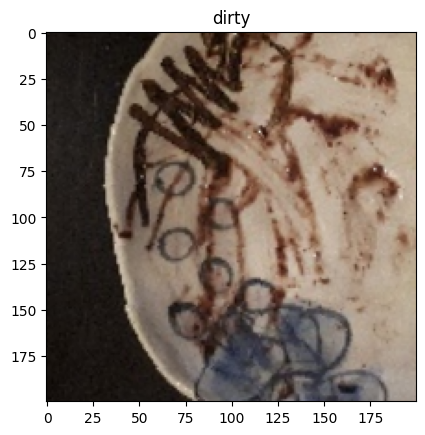

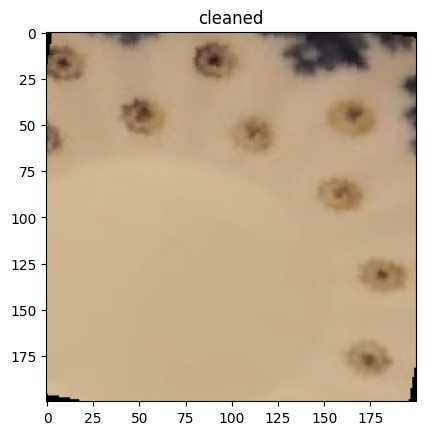

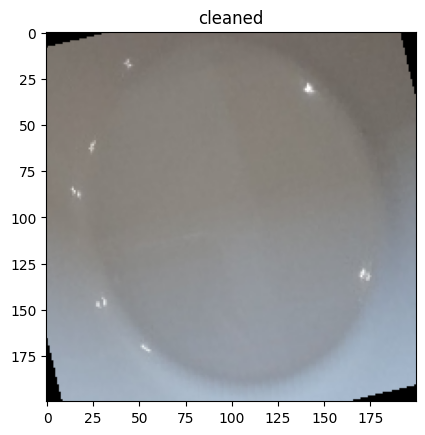

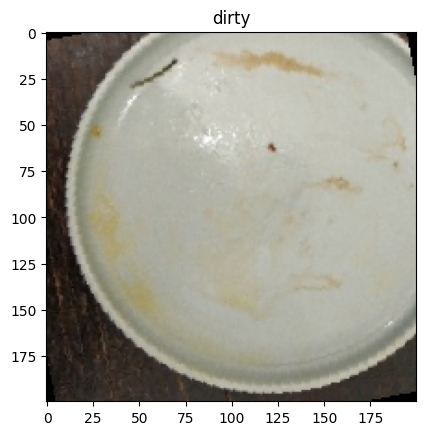

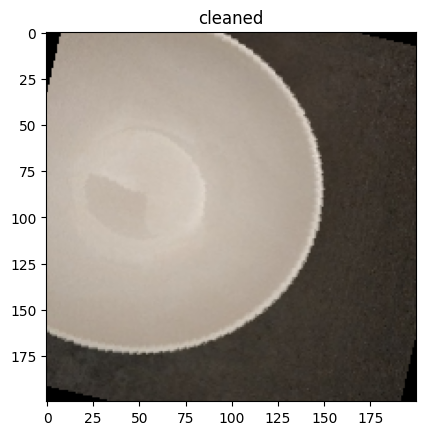

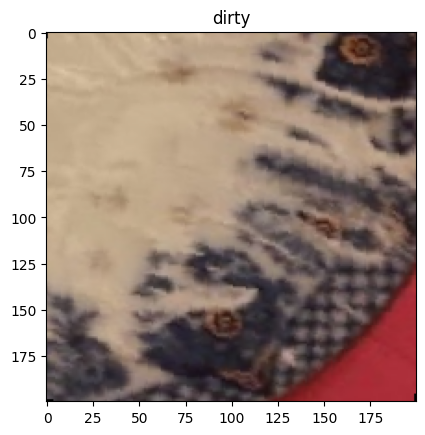

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()
                scheduler.step()
            else:
                dataloader = val_dataloader
                model.eval()
            running_loss = 0.
            running_acc = 0.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [ ]:
model = models.resnet152(pretrained=True)

# Замораживаем все параметры сверточных слоев
for param in model.parameters():
    param.requires_grad = False

# Заменяем последний полносвязный слой на новый с двумя выходными классами
model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Используем планировщик lr_scheduler.ReduceLROnPlateau
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=15)

Epoch 0/14:


100%|██████████| 4/4 [00:18<00:00,  4.74s/it]

train Loss: 0.5244 Acc: 0.8125



100%|██████████| 1/1 [00:04<00:00,  4.18s/it]

val Loss: 0.6226 Acc: 0.6250
Epoch 1/14:



100%|██████████| 4/4 [00:17<00:00,  4.31s/it]

train Loss: 0.4866 Acc: 0.8125



100%|██████████| 1/1 [00:05<00:00,  5.90s/it]

val Loss: 0.5966 Acc: 0.7500
Epoch 2/14:



100%|██████████| 4/4 [00:17<00:00,  4.25s/it]

train Loss: 0.5238 Acc: 0.7812



100%|██████████| 1/1 [00:04<00:00,  4.36s/it]

val Loss: 0.5991 Acc: 0.7500
Epoch 3/14:



100%|██████████| 4/4 [00:16<00:00,  4.25s/it]

train Loss: 0.4909 Acc: 0.7812



100%|██████████| 1/1 [00:06<00:00,  6.17s/it]

val Loss: 0.5916 Acc: 0.7500
Epoch 4/14:



100%|██████████| 4/4 [00:17<00:00,  4.29s/it]

train Loss: 0.4867 Acc: 0.8125



100%|██████████| 1/1 [00:04<00:00,  4.19s/it]

val Loss: 0.5902 Acc: 0.7500
Epoch 5/14:



100%|██████████| 4/4 [00:18<00:00,  4.65s/it]

train Loss: 0.4455 Acc: 0.8750



100%|██████████| 1/1 [00:04<00:00,  4.35s/it]

val Loss: 0.5781 Acc: 0.8750
Epoch 6/14:



100%|██████████| 4/4 [00:16<00:00,  4.24s/it]

train Loss: 0.4833 Acc: 0.8125



100%|██████████| 1/1 [00:06<00:00,  6.31s/it]

val Loss: 0.5773 Acc: 0.8750
Epoch 7/14:



100%|██████████| 4/4 [00:17<00:00,  4.38s/it]

train Loss: 0.4928 Acc: 0.8125



100%|██████████| 1/1 [00:04<00:00,  4.19s/it]

val Loss: 0.5907 Acc: 0.7500
Epoch 8/14:



100%|██████████| 4/4 [00:18<00:00,  4.64s/it]

train Loss: 0.4744 Acc: 0.9062



100%|██████████| 1/1 [00:05<00:00,  5.77s/it]

val Loss: 0.5849 Acc: 0.7500
Epoch 9/14:



100%|██████████| 4/4 [00:27<00:00,  6.83s/it]

train Loss: 0.4982 Acc: 0.8438



100%|██████████| 1/1 [00:06<00:00,  6.79s/it]

val Loss: 0.5863 Acc: 0.6250
Epoch 10/14:



100%|██████████| 4/4 [00:17<00:00,  4.35s/it]

train Loss: 0.5721 Acc: 0.6875



100%|██████████| 1/1 [00:05<00:00,  5.96s/it]

val Loss: 0.5884 Acc: 0.7500
Epoch 11/14:



100%|██████████| 4/4 [00:17<00:00,  4.30s/it]

train Loss: 0.5137 Acc: 0.7812



100%|██████████| 1/1 [00:04<00:00,  4.23s/it]

val Loss: 0.5827 Acc: 0.7500
Epoch 12/14:



100%|██████████| 4/4 [00:18<00:00,  4.55s/it]

train Loss: 0.4442 Acc: 0.8750



100%|██████████| 1/1 [00:04<00:00,  4.90s/it]

val Loss: 0.5941 Acc: 0.7500
Epoch 13/14:



100%|██████████| 4/4 [00:17<00:00,  4.25s/it]

train Loss: 0.5434 Acc: 0.7500



100%|██████████| 1/1 [00:04<00:00,  4.22s/it]

val Loss: 0.5836 Acc: 0.7500
Epoch 14/14:



100%|██████████| 4/4 [00:18<00:00,  4.67s/it]

train Loss: 0.5020 Acc: 0.8125



100%|██████████| 1/1 [00:04<00:00,  4.21s/it]

val Loss: 0.5798 Acc: 0.8750


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
data_root

'/content/plates/'

In [ ]:
test_dir = '/content/plates/test'

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)

test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [06:40<00:00,  4.31s/it]


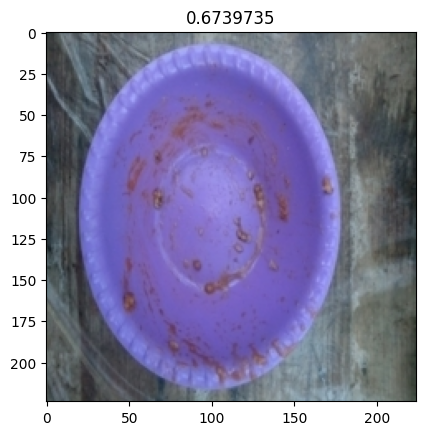

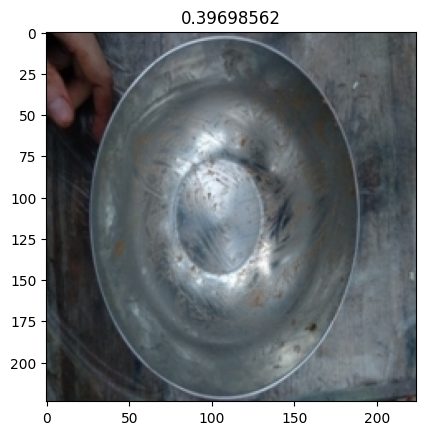

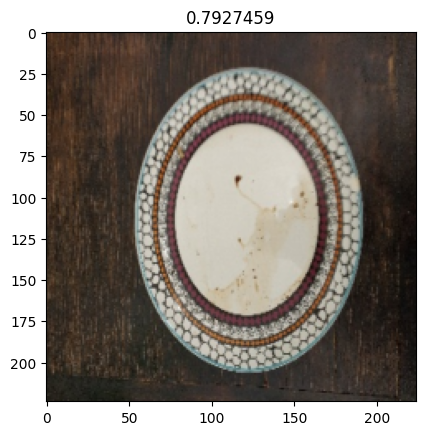

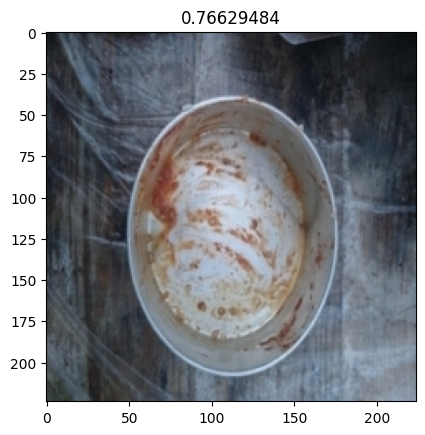

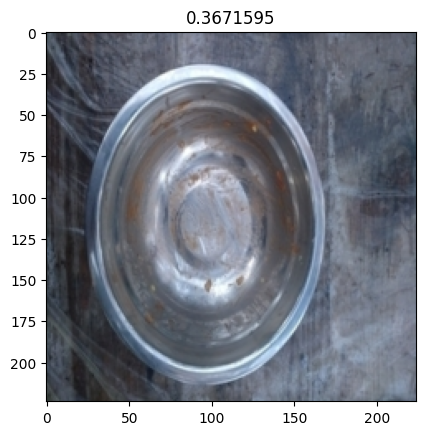

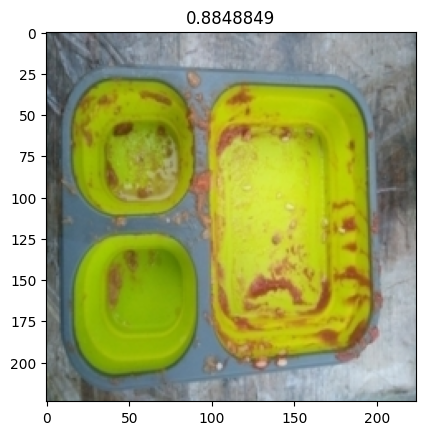

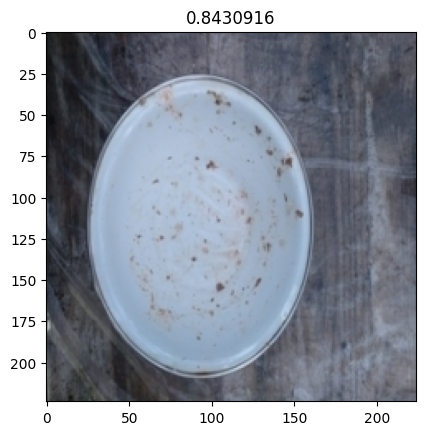

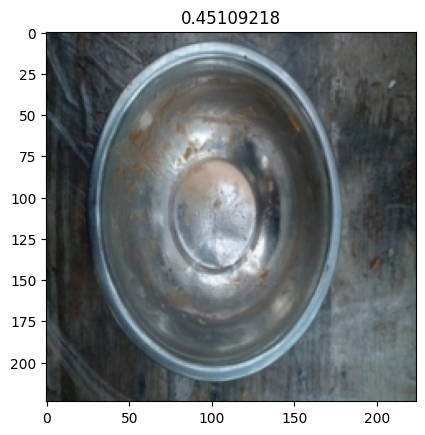

In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.55 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/content/plates/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,cleaned
0002,dirty
0003,dirty
0004,cleaned
0005,dirty


In [ ]:
submission_df.to_csv('/content/submission.csv')